# Running the DiuSST model and plotting results

Date: 20 Mar 2022

This tutorial provides a complete example of running the DiuSST model using real atmospheric forcing data.

First, we need to load the required standard modules (numpy, matplotlib, pandas) as well as the custom modules containing the code for DiuSST.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# Access source code
import sys
sys.path.append('../src')

# Load DiuSST model
from diusst import Diusst

## Load dataset

Now, we load the dataset (from the MOCE-5 cruise in the Eastern Pacific and Gulf of California) and store it as a pandas DataFrame.

In [3]:
data_path = '../input_data/moce5/'
data_filename = 'training_moce5_err-boatspd-x2_humid10.csv'

data_orig = pd.read_csv(data_path+data_filename)
data_orig

,times,sst,sst_err,ftemp,wind,atemp,swrad,humid,boatspd
0,31625.760,291.797,0.147397,291.538,0.947,290.451,695.5,0.01,12.3
1,32321.472,292.099,0.085068,291.222,1.015,290.947,635.6,0.01,12.4
2,33008.616,292.336,0.147397,291.748,1.167,290.868,559.7,0.01,12.3
3,35765.736,293.311,0.063959,290.777,1.739,291.826,737.2,0.01,1.5
4,36452.880,291.097,0.070329,291.185,2.471,291.596,774.3,0.01,0.5
...,...,...,...,...,...,...,...,...,...
1847,1736233.800,291.047,0.233219,291.618,1.458,291.480,0.5,0.01,8.1
1848,1736879.760,290.679,0.107123,291.191,1.189,291.589,0.5,0.01,8.4
1849,1737525.360,290.740,0.106192,291.205,0.435,291.640,0.6,0.01,8.2
1850,1738171.200,290.996,0.087068,291.312,0.900,291.616,0.6,0.01,8.1


## Specify model settings

In the next cell, we specify all the parameters and other options for the simulation.

In [4]:
# Foundation temperature
T_f = np.mean(data_orig['ftemp'].to_numpy(np.float64))
print('Foundation temperature: {:.2f} K'.format(T_f))

# Key parameters
kappa = 1.799e-4
mu = 0.002576
alpha = 2.445
sigma = 0.8

# Options
diffu_profile = 'LIN'
CFL = 0.95

# Domain
z_f = 10
dz0 = 0.1
ngrid = 20

# Create model instance
model = Diusst(T_f=T_f, kappa=kappa, mu=mu, alpha=alpha, sigma=sigma,
                diffu_profile=diffu_profile, CFL=CFL, z_f=z_f, dz0=dz0, ngrid=ngrid)

Foundation temperature: 298.19 K


## Interpolate original data

The original dataset has a time intervals of several minutes. If we would input this time series directly into the model, the simulation would become instable because the CFL condition will not be met. Therefore, we must interpolate the dataset such that the time step between adjacent data points is small enough to satisfy the CFL condition. For this purpose, we have written the `interpolation` function which we call below. It adapts the time step to the current wind conditions in order to save computation time.

In [5]:
data_intp, dtlist, idx = model.interpolate(data_orig)

Variable time-step interpolation at CFL = 0.95:
---> Interpolated dataset has 1316609 time steps with average length 3.209 s.
---> Constant dt interpolation would require dt = 0.298 s --> 5732218 steps.
---> Computation time will be reduced by 77.031 %.


## Run the model

We are ready to run the DiuSST model! This works by calling the `simulate` function.

In [6]:
simu = model.simulate(data_intp)

100%|██████████████████████████████████████████████████| 1316608/1316608 [03:13<00:00, 6805.49it/s]


The dataset provides the temperature difference between the sea skin (SST) and the water temperature at 3m depth (ftemp). Therefore, to compare our simulation with the observational data, we must find the grid point closest to 3m depth and take the temperature difference with respect to that grid point.

In [6]:
ref_level = int(20)
simu_sst = simu[0][:,0]-simu[0][:,ref_level]

print('Reference depth (in m) at which the SST difference is taken: ',round(simu[2][ref_level],2))

Reference depth (in m) at which the SST difference is taken:  -3.05


## Plot results

Finally, let us plot the results of our simulation.

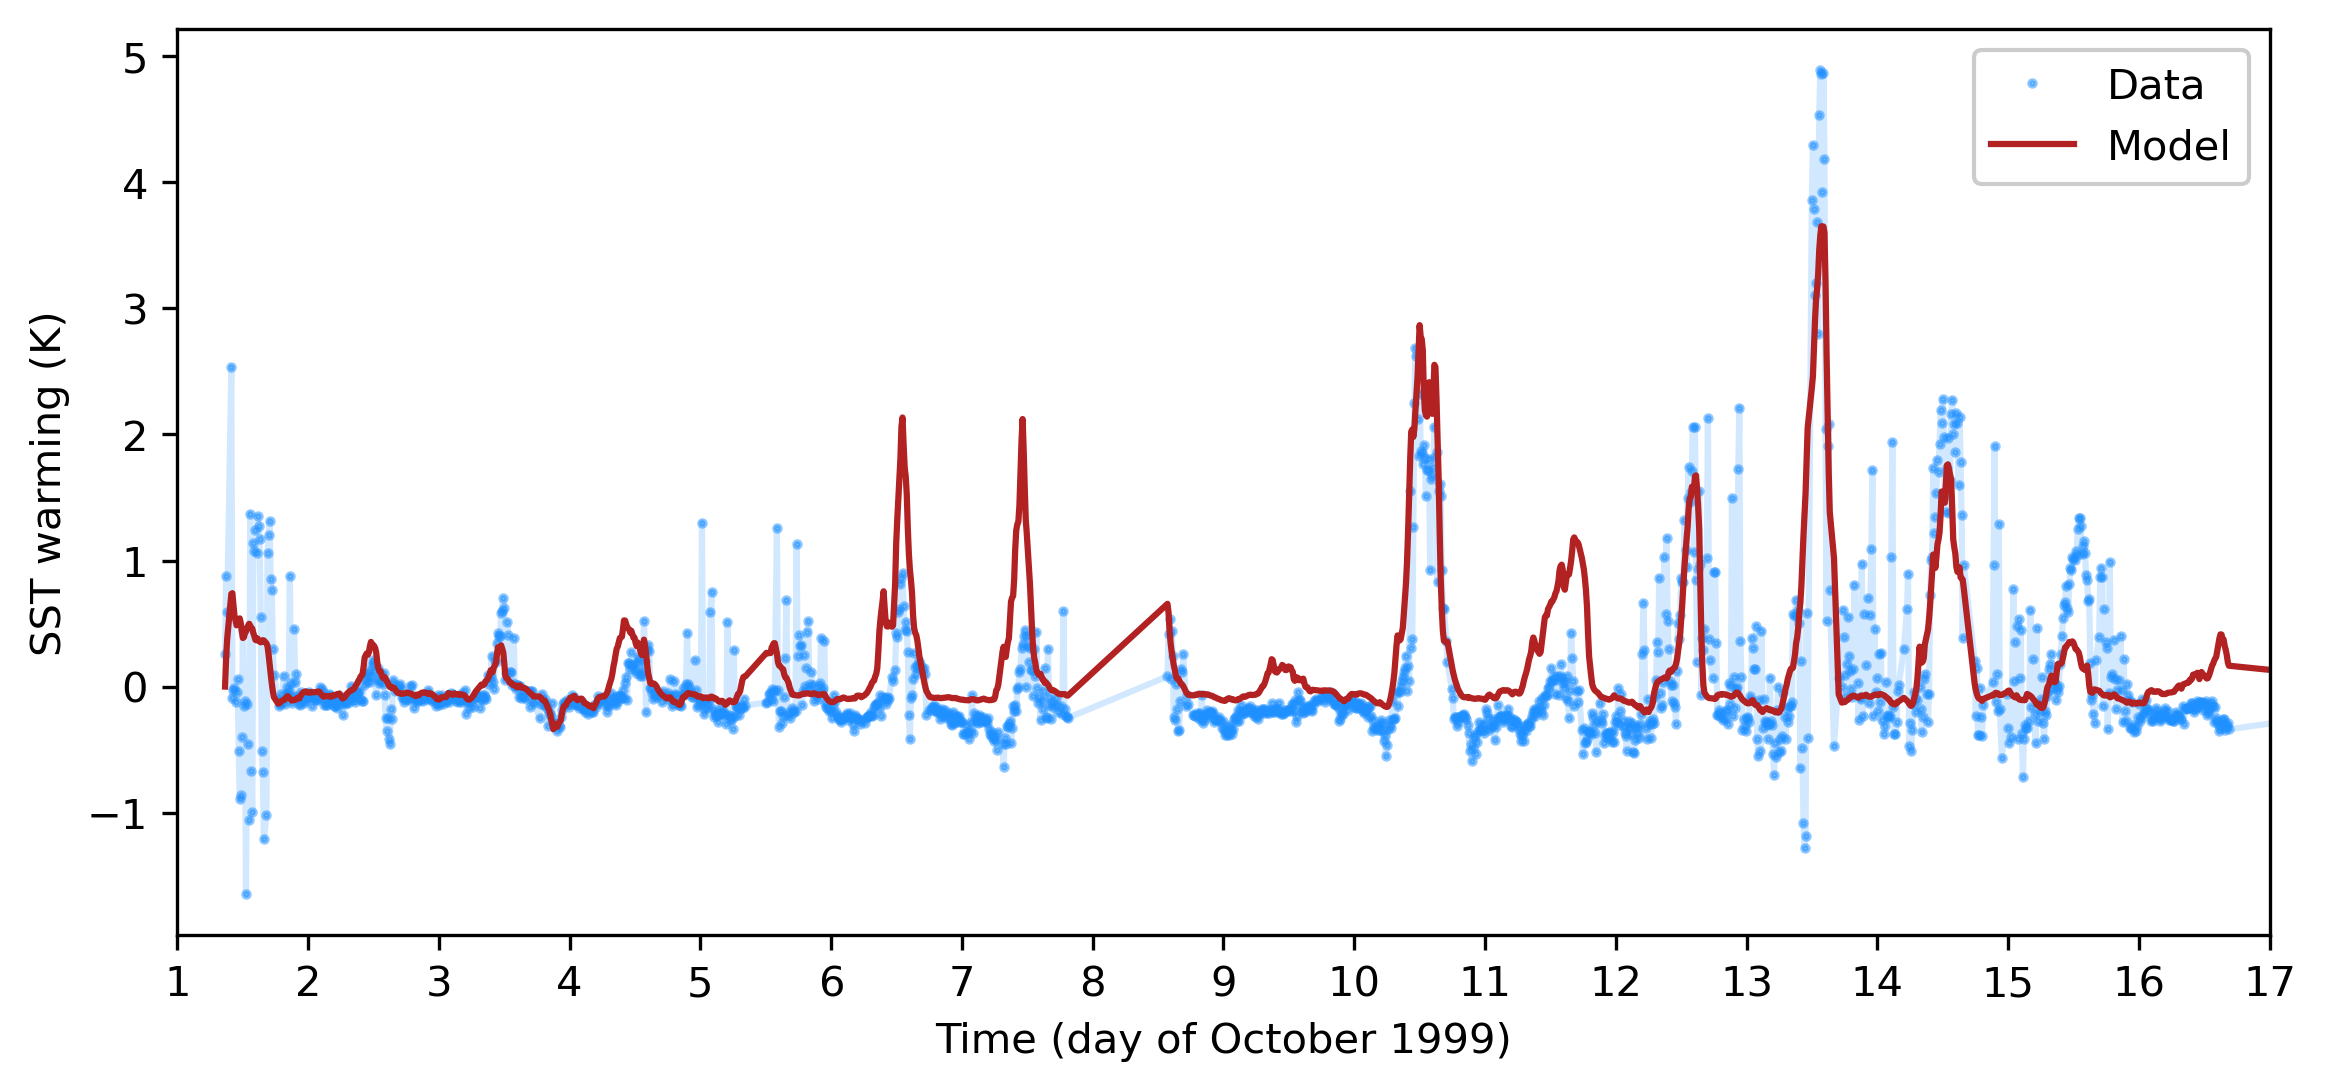

In [7]:
fig, ax = plt.subplots(dpi=300,figsize=(9,4))

ax.plot(data_orig['times']/86400,data_orig['sst']-data_orig['ftemp'],alpha=0.2,c='dodgerblue')
ax.plot(data_orig['times']/86400,data_orig['sst']-data_orig['ftemp'],'.',markersize=3,alpha=0.5,c='dodgerblue', label='Data')
ax.plot(data_orig['times'][:-1]/86400,simu_sst[idx],c='firebrick', label='Model')

ax.legend(framealpha=1)
ax.set(xlim=(0,20.5),xticks=np.arange(0,21),xticklabels=np.arange(0,21)+1)
#ax.set_ylim(-2,6)
ax.set_xlim(0,16)
ax.set(xlabel='Time (day of October 1999)')
ax.set(ylabel='SST warming (K)')

plt.show()

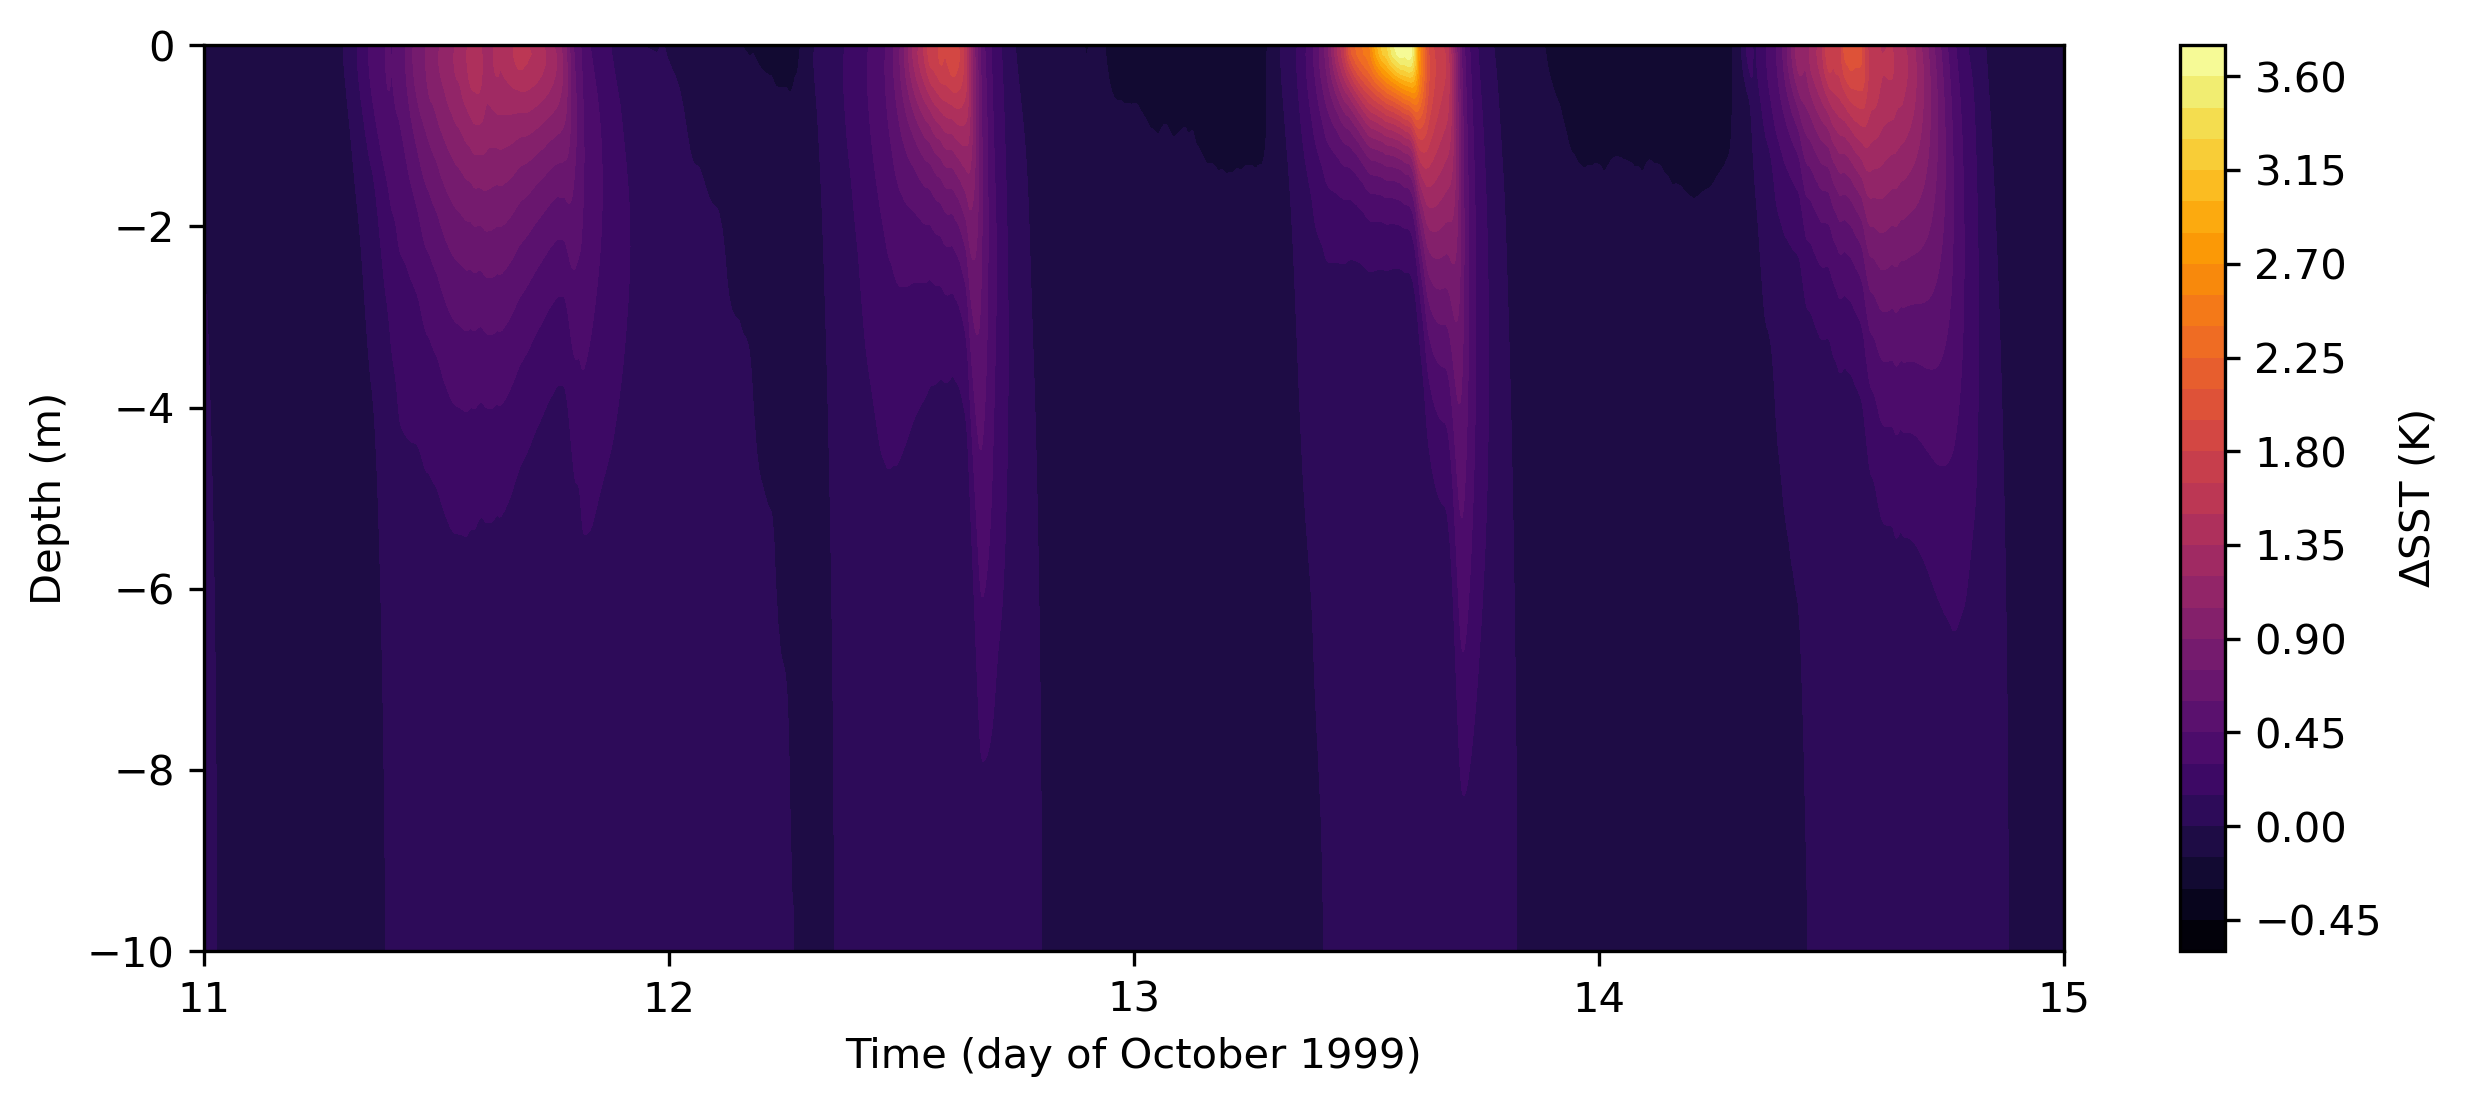

In [8]:
fig, ax = plt.subplots(dpi=300,figsize=(10,4))
plot = ax.contourf(simu[1]/86400,simu[2],simu[0].transpose()-T_f,levels=30,cmap='inferno')

ax.set(xlim=(0,20.5),xticks=np.arange(0,21),xticklabels=np.arange(0,21)+1)
ax.set(xlabel='Time (day of October 1999)', ylabel='Depth (m)')
ax.set(ylim=(-10,0), xlim=(10,14))
plt.colorbar(plot,label='$\Delta$SST (K)')

plt.show()

That's it!